# Manual NER 
Pipeline to detect specimen codes in article text
- Sources: UMMZ papers
- Labels: manually generated with NVIVO

Steps:
1. **Make training data**: tokenize sentences from papers; if label in sentence, export.
2. **Train NER model**: split exported labels into train/dev; train transformer-based NER model.
3. **Apply NER model**: parse all papers in bibliography; extract specimen entities from sentences.

## 1. Make training data
Prepare training data from codes and papers. Does not require accelerator (GPU).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import glob
import json
import re
import random
from tqdm import tqdm
import pysbd
seg = pysbd.Segmenter(language="en", clean=False) # sentence segmenter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import spacy
from spacy.tokens import DocBin
from spacy import displacy

In [26]:
def clean_text(txt):
    """
    Removes special characters, punctuation, and returns lowercase
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def clean_text2(txt):
    """
    Removes special characters and punctuation
    """
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt))

def alphanum(txt):
    """
    Extracts alphanumeric characters without spaces
    """
    return "".join(x.lower() for x in txt if x.isalnum())

def extract_pat(search_str:str, search_list:str):
    """
    Defines pattern to search for
    """
    search_obj = re.search(search_list, search_str)
    if search_obj:
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = "None"
    return return_str

def json2txt_df(json_file_path):
    """
    Extract body text of json file
    """
    with open(json_file_path, 'r') as f:
        data = json.loads(f.read())
        body_text_df = pd.json_normalize(data["pdf_parse"]["body_text"])
    
    return body_text_df

def df2sentences(df):
    """
    Tokenize and clean sentences
    """
    sentences_text = " ".join(list(df.text)) 
    pattern_brackets = re.compile(r'\(.*?\)')
    sentences_text = re.sub(pattern_brackets, "", sentences_text) 
    sentences = seg.segment(sentences_text) 
    sentences = [re.sub(r"^\W+", "", sentence) for sentence in sentences] 
    sentences = [re.sub(r"\s+", " ", sentence) for sentence in sentences]
    return sentences

def prep_data(json_file_path, ref_id):
    """
    Return sentence lists for matches
    """
    body_text_df = json2txt_df(json_file_path)
    sentences = df2sentences(body_text_df)
    candidates = []
    for sentence in sentences:
        doc = nlp(sentence)
        matches = matcher(doc)
        if len(matches) > 0:
            sentence_dict = {"text":sentence,
                             "meta":{"ref_id":str(ref_id)}}
            candidates.append(sentence_dict)    
    return candidates

Extract column headers as search codes
1. UMMZ codebook - Faye
2. UMMZ codebook - Katherine

In [3]:
df_ummz_1 = pd.read_csv('../labels/manual/Faye_UMMZ.csv',encoding='utf-8')
names_1 = df_ummz_1.Name.to_list()
codes_ummz_1 = [i.replace("(", "").replace(")", "").strip() for i in names_1]
print("UMMZ codes by Faye:",len(codes_ummz_1))

df_ummz_2 = pd.read_csv('../labels/manual/Katherine_UMMZ.csv',encoding='utf-8')
names_2 = df_ummz_2.Name.to_list()
codes_ummz_2 = [i.replace("(", "").replace(")", "").strip() for i in names_2]
print("UMMZ codes by Katherine:",len(codes_ummz_2))

combined_codes = codes_ummz_1+codes_ummz_2

print("All codes:",len(combined_codes))
codes_pattern = '|'.join(combined_codes)

UMMZ codes by Faye: 380
UMMZ codes by Katherine: 81
All codes: 461


In [4]:
codes_pattern

'AMNH 3111~2433, 3111~2434, 3114~2437, 148969, 149104, 165651, 165653|FMNH 14717|FMNH 16730|FMNH 9512|FMNH 95122 [holotype], 147172, 14717|OMNH 17373|, NMP 468|, USNM 573505, 573834-57584|1 FMNH 169122-169124; 170965-17096|AMNH 12454|AMNH 130501, 130503, 130504, 130507, 130509– 130511, 130559|AMNH 130510|AMNH 131732, 131737, 136863, 136865, 136866, 137288, 137997, 137999, 139280, 139780|AMNH 140466|AMNH 147759|AMNH 167852|AMNH 185270|AMNH 208101|AMNH 209159, 209160, 210398–210400, 275463, 275465–275467|AMNH 244364|AMNH 259983|AMNH 266416, 266417, 267368, 267816|AMNH 266427–266434, 267369–267371, ~~267818|AMNH 267339|AMNH 267342|AMNH 267344|AMNH 268214, 272816, 273062, 273063, 273178, 273188|AMNH 269997|AMNH 272667|AMNH 272695|AMNH 272760|AMNH 272775|AMNH 272780|AMNH 272782|AMNH 272809|AMNH 272816|AMNH 272816 ~~|AMNH 272818|AMNH 272836|AMNH 272870|AMNH 273038|AMNH 273186 ~~|AMNH 276586|AMNH 276743|AMNH 276745|AMNH 276746|AMNH 276751|AMNH 276753|AMNH 276754|AMNH 276757|AMNH 277680–277682

Read in and tokenize sentences from UMMZ papers

In [5]:
%%time

ummz_papers = glob.glob('../papers/*.json')

df_train_pubs = pd.DataFrame()
for train_file in ummz_papers: 
    with open(train_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_train_pubs = pd.concat([df_train_pubs, file_data])

train_sentences = []

for row in df_train_pubs.itertuples():
    for sent in seg.segment(row[1]):
        train_sentences.append((row[7], row[5], row[7], sent))
        
df_train = pd.DataFrame(train_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_train['sent'] = df_train['sent'].astype(str)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251706 entries, 0 to 251705
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Id             251706 non-null  object
 1   section_title  251706 non-null  object
 2   paper_title    251706 non-null  object
 3   sent           251706 non-null  object
dtypes: object(4)
memory usage: 7.7+ MB
CPU times: user 4min 12s, sys: 658 ms, total: 4min 13s
Wall time: 8min 29s


Search for codes in paper sentences; clean codes and sentences

In [ ]:
print(f"Searching {len(glob.glob('../papers/*.json'))} papers for specimen codes")
df_ummz_sent['code'] = df_ummz_sent['sent'].apply(lambda x: extract_pat(search_str=x, search_list=codes_pattern))
df_ummz_sent['has_code'] = (df_ummz_sent['code'] != "None")
df_ummz_sent.code.value_counts()

In [7]:
print("Unique papers: ", df_train.Id.nunique())
print("Unique labels: ", df_train.code.nunique())

Unique papers:  510
Unique labels:  49


Resize so equal number of True and False sentences containing codes

In [8]:
df_train_majority = df_train[df_train.has_code==False]
df_train_minority = df_train[df_train.has_code==True]

df_train_downsampled = resample(df_train_majority, replace=False, n_samples=len(df_train_minority), random_state=1)
df_train_codes = pd.concat([df_train_downsampled, df_train_minority])

df_train_codes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1306 entries, 160246 to 251535
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1306 non-null   object
 1   section_title  1306 non-null   object
 2   paper_title    1306 non-null   object
 3   sent           1306 non-null   object
 4   code           1306 non-null   object
 5   has_code       1306 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 62.5+ KB


In [9]:
df_train_codes[df_train_codes.has_code==True]

,Id,section_title,paper_title,sent,code,has_code
1928,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,DESCRIPTION,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,The tips of most Conophis organs I examined ar...,UMMZ,True
1986,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,6,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,"In addition, notes on another (living) specime...",UMMZ,True
2001,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,8,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,A third specimen (UMMZ 124224) was said by Tes...,UMMZ,True
2163,,DENTAL ABNORMALITY IN THE GENUS CASTOR,,While examining a collection of 13-3 specimens...,UMMZ,True
2164,,DENTAL ABNORMALITY IN THE GENUS CASTOR,,Both upper third molars are present in the sku...,UMMZ,True
...,...,...,...,...,...,...
241613,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",MATERIALS,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",Large series of Neobawettia were studied in th...,UMMZ,True
242310,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",DISTRIUUT~ON (Figs. 9 and 24,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",NW Mazatlzin Airport; El Venadillo (4.5 mi. NE...,UMMZ,True
242422,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",53,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...","NW Guasave (UMMZ, TINK); 42, 19, 8 mi.",UMMZ,True
242979,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",rI'IIEOL)ORE J. COI-IN,"MISCELLANEOUS PUBLICATIONS MUSEUM OF ZOOLOGY, ...",Meso-and tnetanota entirely jet black or very ...,UMMZ,True


Get `specimen_code` entity spans for positive examples and set as 0,0 for negative examples

In [10]:
%%time

POSITIVE_DATA = []
NEGATIVE_DATA = []

for idx, row in df_train_codes.iterrows():
    label = row.code
    sentence = row.sent
    label2 = clean_text(label)
    sentence2 = clean_text(sentence)
    a = re.search(label2, sentence2)
    if row.has_code == False:
        NEGATIVE_DATA.append((clean_text2(sentence),{"entities":[(0,0,"SPECIMEN")]}))
    else:
        POSITIVE_DATA.append((clean_text2(sentence),{"entities":[(a.span()[0],a.span()[1],"SPECIMEN")]}))

CPU times: user 103 ms, sys: 992 µs, total: 104 ms
Wall time: 210 ms


In [11]:
POSITIVE_DATA[:10]

[('The tips of most Conophis organs I examined are not quite everted AMNH 66337 123917 126423 but in the one illustrated by Wellman UMMZ 82650 the apex of each short bilobation has at the terminus of the sulcus a hard nearly nude slightly papillate bump or projection the mistaken disc ',
  {'entities': [(129, 133, 'SPECIMEN')]}),
 ('In addition notes on another living specimen from Rancho Grande were provided by the late Scott J Maness in litt Dec 2 1974 8 HEMIPENIS The left uneverted organ of UMMZ 124221 extends in situ to the end of subcaudal 8 being bifurcated from the base of subcaudal 7 and with the two slips of the major retractor muscle merging at the end of subcaudal 9 the major retractor muscle originates at the level ofsubcaudal 24 ',
  {'entities': [(164, 168, 'SPECIMEN')]}),
 ('A third specimen UMMZ 124224 was said by Test et al 1966 p 44 to have had the belly gray with pinkish flush and the interstripe areas posteriorly a pale brown I would add that the specimen mentioned 

In [12]:
NEGATIVE_DATA[:10]

[('Dorsal ventral coun tershading apparent in most species indistinct in two but without pronounced lateral line ',
  {'entities': [(0, 0, 'SPECIMEN')]}),
 ('Among many semiaquatic carnivorous small mammals conspicuous enlargement of the medulla oblongata and the cerebrum does indeed appear to be consistently correlated with increased vibrissal density and sensitivity Bauchot and Stephan 1968 Rehkiimper 1981 Stephan and Kuhn 1982 Stephan and Dieterlen 1982 ',
  {'entities': [(0, 0, 'SPECIMEN')]}),
 ('There is disproportionate development of the interparietals in the various subspecies of Liomys in watus ',
  {'entities': [(0, 0, 'SPECIMEN')]}),
 ('Not one ofthe five lives in undisturbed primary forest formations all are restricted to habitats associated with human activity cities harbors villages agricultural fields scrub tropical gardens and second growth forest near villages and towns ',
  {'entities': [(0, 0, 'SPECIMEN')]}),
 ('This is in spite of our measuring age for females in gr

Split labeled data into TRAIN (90), TEST (10) data set - held out for model evaluation

In [13]:
COMBO_DATA = np.array(NEGATIVE_DATA + POSITIVE_DATA)
random.seed(1)
random.shuffle(COMBO_DATA)

TRAIN_DATA, TEST_DATA = train_test_split(COMBO_DATA, test_size=(0.1), random_state=1)

print("Training instances: ", len(TRAIN_DATA))
print("Testing instances: ", len(TEST_DATA))

Training instances:  1175
Testing instances:  131


In [14]:
TRAIN_DATA[:10]

array([['These haplotypes along with the others gathered from Deltamys specimens were employed in population level comparisons ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Remarks One of the specimens we refer to Marmosa jansae BMNH 11 7 19 20 was identified by Tate 1933 80 as M germana germana but later in the same publication on p 82 he identified two other specimens AMNH 64025 68142 as M germana rutteri ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Never have I seen any indication of antagonism between individuals either i n captivity or in the wild ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Pelage dense long and lax ', {'entities': [(0, 0, 'SPECIMEN')]}],
       ['We now have counts of documents in each of the four categories ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['The derived conditions follow ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Alouatta seniculus bogotensis Allen Bull ',
        {'entities': [(0, 0, 'SPECI

In [15]:
TEST_DATA[:10]

array([['Text figure 8K shows the pit starting to form ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Short term weather fluctuations can cause significant demographic trends both in sex ratio and litter size and also affect body weight ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['In the desert belt there are the unexpected records by Blair 41 from several associations on the desert plain near Tularosa ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['sylvaticus A alpicola A microps A hermonensis and A mystacinus ',
        {'entities': [(0, 0, 'SPECIMEN')]}],
       ['Hammond L S derstr m and R S Voss from 1913 Voss from to 1980 seven of these specimens are at the BMNH and the eighth is at the UMMZ ',
        {'entities': [(128, 132, 'SPECIMEN')]}],
       ['Frugivorous bats are conspicuously absent in rnost parts of the Chaco with all present records either from comparatively mesic areas along the Rio Paraguay o r from that time of year late winter August

## 2. Train NER model

Pipeline will detect `SPECIMEN` as a custom entity. Requires accelerator (GPU).

In [16]:
print(spacy.__version__)

3.3.1


In [17]:
# print(spacy.require_gpu())

In [18]:
# nlp = spacy.blank("en")

# db_train = DocBin()
# db_test = DocBin()

In [19]:
# for text, annot in tqdm(TRAIN_DATA):
#     doc = nlp.make_doc(text)
#     ents = []
#     for start, end, label in annot["entities"]:
#         span = doc.char_span(start, end, label=label, alignment_mode="contract")
#         if span is None:
#             pass
#         else:
#             ents.append(span)
#     doc.ents = ents
#     db_train.add(doc)

# db_train.to_disk("../models/manual/train.spacy")

In [20]:
# for text, annot in tqdm(TEST_DATA):
#     doc = nlp.make_doc(text)
#     ents = []
#     for start, end, label in annot["entities"]:
#         span = doc.char_span(start, end, label=label, alignment_mode="contract")
#         if span is None:
#             pass
#         else:
#             ents.append(span)
#     doc.ents = ents
#     db_test.add(doc)

# db_test.to_disk("../models/manual/dev.spacy")

## Train and save NER model
Use command-line interface (CLI) so program sources spaCy correctly

In [21]:
# !python -m spacy train ../models/manual/config.cfg --output ../models/manual/ --paths.train ../models/manual/train.spacy --paths.dev ../models/manual/dev.spacy --gpu-id 0

## 3. Apply NER model
Extract `SPECIMEN` codes from papers in the UMMZ bibliography. Accelerator (GPU) optional.

In [22]:
custom_ner_model = spacy.load("../models/manual/model-best/")

Apply NER model to the full text of papers from UMMZ bibliography

In [23]:
%%time

df_test_pubs = pd.DataFrame()
for test_file in ummz_papers: 
    with open(test_file, 'r') as f:
        data = json.loads(f.read())
        file_data = pd.json_normalize(data["pdf_parse"]["body_text"])
        file_data["paper_id"] = data["title"]
    df_test_pubs = pd.concat([df_test_pubs, file_data])

ummz_sentences = []

for row in df_test_pubs.itertuples():
    for sent in seg.segment(row[1]):
        ummz_sentences.append((row[7], row[5], row[7], sent))
        
df_ummz_sent = pd.DataFrame(ummz_sentences, columns=['Id', 'section_title', 'paper_title', 'sent'])
df_ummz_sent['sent'] = df_ummz_sent['sent'].astype(str)

papers_sample = random.sample(ummz_papers, 1)

def extract_ents(text):
    """
    Extract named entities, and beginning, middle and end idx     
    """
    doc = custom_ner_model(text)
    if len(doc.ents) > 0:
        return clean_text2(doc.ents)
    else:
        return None

def predict_ents(df):
    """
    Create new column in data frame with named entity tuple extracted
    """
    df_ummz_sent['specimen_prediction'] = df_ummz_sent['sent'].apply(extract_ents)
    
predict_ents(df_ummz_sent)

df_ummz_sent['specimen_prediction'].value_counts().sort_values(ascending=False)

/sw/arcts/centos7/python/3.9.7/pytorch/1.10.2/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 8h 41min 51s, sys: 2min 2s, total: 8h 43min 53s
Wall time: 17h 22min 43s


 UMMZ              500
 AMNH              100
 MVZ                37
 FMNH               33
 UM                 29
                  ... 
 UMMZ13              1
 AMNH departed       1
 AMNH 185323         1
 AMNH as             1
 FMNH 172248         1
Name: specimen_prediction, Length: 1272, dtype: int64

Demonstrate model predictions with a randomly sampled paper in the UMMZ bibliography

In [30]:
%%time

papers_sample = random.sample(ummz_papers, 1)

for file in papers_sample:
    ref_id = file.split("/")[-1].split("-")[0]
    print(f"Searching for SPECIMEN entities in paper: {ref_id}")
    body_text_df = json2txt_df(file)
    sentence_list = df2sentences(body_text_df)
    for sentence in sentence_list:
        clean_sent = clean_text2(sentence)
        doc = custom_ner_model(clean_sent)
        if len(doc.ents) > 0:
            displacy.render(doc, style="ent", jupyter=True)

Searching for SPECIMEN entities in paper: 798.1.json


/sw/arcts/centos7/python/3.9.7/pytorch/1.10.2/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


CPU times: user 2min 34s, sys: 519 ms, total: 2min 34s
Wall time: 2min 39s


Show the most frequently extracted specimen codes from available UMMZ Bibliography papers

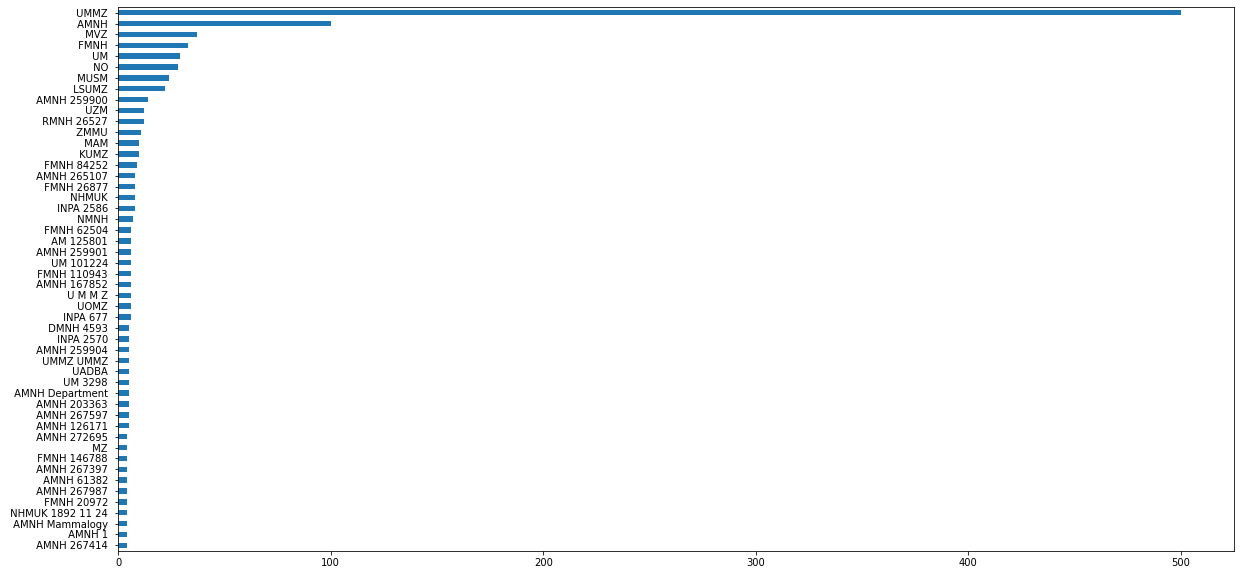

In [31]:
ax = df_ummz_sent['specimen_prediction'].value_counts().nlargest(50).sort_values().plot(kind='barh',figsize=(20,10))
ax.figure.savefig('../results/manual_count.png', dpi=300)


Top, unique entities across papers in available papers in UMMZ Bibliogrpahy


In [32]:
ummz_unique_codes = set(df_ummz_sent['specimen_prediction'].unique())
len(ummz_unique_codes)

1273

In [33]:
predictions_ummz = df_ummz_sent[df_ummz_sent.specimen_prediction.notna()]
predictions_ummz = predictions_ummz[predictions_ummz.Id.notna()]
predictions_ummz['paper'] = predictions_ummz['Id'].astype("category").cat.codes
predictions_ummz['Id'] = predictions_ummz[['Id','paper','specimen_prediction']].groupby(['specimen_prediction','paper'])['Id'].transform(lambda x: ','.join(x))
predictions_ummz.to_csv('../results/manual_predictions.csv',index=False)
predictions_ummz.head()

,Id,section_title,paper_title,sent,specimen_prediction,paper
41,",,,,,,,,,,,,,","Isothrix barbarabrownae, new species",,"-MUSM 16819 (Museo de Historia Natural, Univer...",MUSM,0
708,The Smithsonian Institution African Mammal Pro...,AMP and Earlier Smithsonian African Expeditions,The Smithsonian Institution African Mammal Pro...,The 39 new forms so far issuing from the AMP (...,USNM 470588 USNM 402309,169
1856,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,"Liophis problematicus, new species",AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,"Figures 1-6 HOLOTYPE: FMNH 64733, an adult mal...",FMNH 64733,31
1925,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,DESCRIPTION,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,The following examples are relevant: Thompson ...,AMNH 104667,31
1928,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,DESCRIPTION,AMERICAN MUSEUM Novitates PUBLISHED BY THE AME...,The tips of most Conophis organs I examined ar...,AMNH 66337 UMMZ,31


In [34]:
predictions_ummz_dedup = predictions_ummz[['specimen_prediction','Id','paper']].drop_duplicates()
cross_df = pd.crosstab(predictions_ummz_dedup.specimen_prediction, predictions_ummz_dedup.paper, margins=True, dropna=False)
cross_df.to_csv('../results/manual_frequencies.csv')
cross_df.head()

paper,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,All
specimen_prediction,,,,,,,,,,,,,,,,,,,,,
,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17 UMMZ,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AJ251400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AK8207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
